# Risk Parity portfolio

Risk parity portfolios allocate equal amounts of risk for each stock towards the overall risk of the portfolio. For instance, if we have a 5 stock portfolio, each of these will allocate 20% of risk. Based on this risk allocation, we find the optimal weights in terms of dollar amounts which we invest in each of those stocks. This is a sophisticated diversification technique that focuses on risk analysis. 

Data is from the Ken French Website on 12 US industries. I will be allocating between 5 different industries.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

ind_12_ew = pd.read_csv("12_Industry_Portfolios.csv", 
                     header = 0, index_col = 0, parse_dates = True, na_values=-99.99)/100
ind_12_ew.index = pd.to_datetime(ind_12_ew.index, format = '%Y%m').to_period('M')
ind_12_ew.columns = ind_12_ew.columns.str.strip()
ind = ["Manuf", "Enrgy", "Telcm", "Utils", "Hlth"]
rets = ind_12_ew["2010":][ind]
rets.tail()

,Manuf,Enrgy,Telcm,Utils,Hlth
2019-12,0.0345,0.2038,0.0367,0.0442,0.0966
2020-01,-0.0293,-0.1972,-0.0082,0.0120,0.0426
2020-02,-0.0819,-0.1856,-0.0463,-0.1017,-0.0081
2020-03,-0.2458,-0.4746,-0.2354,-0.1036,-0.1728
2020-04,0.1651,0.6777,0.1042,0.0828,0.2168


In [22]:
cov = rets.cov()

# Equal-weights function
def equal_weights(rets):
    n = len(rets.columns)
    weights = pd.Series(1/n, index = rets.columns)
    return weights

# Portfolio Volatility
def pf_vol(weights, cov):
    return (weights.T @ cov @ weights)**0.5

# Risk-contributions for each asset towards the overall portfolio volatility
def risk_cont(weights, cov):
    pf_volatility = pf_vol(weights, cov) ** 2
    risk = cov@weights
    risk_contribution = np.multiply(risk, weights.T)/pf_volatility
    return risk_contribution

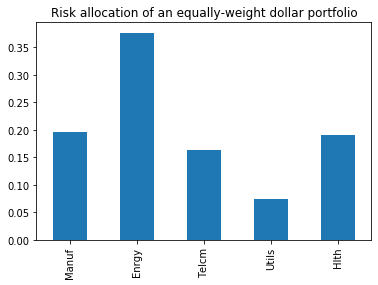

In [23]:
# Risk-contributions for an equally-weighted portfolio
risk_cont(equal_weights(rets), cov).plot.bar(title = "Risk allocation of an equally-weight dollar portfolio")

In [29]:
from scipy.optimize import minimize

# Find optimal dollar weights such that the risk-contributions meet a target contribution level, in this case being 1/n = 0.2 for each asset

def t_risk_cont(t_risk, cov):
    n = cov.shape[0]
    initial_guess = np.repeat(1/n, n)
    bounds = ((0, 1),) * n
    weights_constraint = {'type': 'eq',
                         'fun': lambda weights: np.sum(weights) - 1}
    def msd(weights, t_risk, cov):
        contributions = risk_cont(weights, cov)
        return ((contributions - t_risk)**2).sum()
    
    weights = minimize(msd, initial_guess,
                       args=(t_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_constraint,),
                       bounds=bounds)
    return weights.x

def equal_risk_cont(cov):
    n = cov.shape[0]
    return t_risk_cont(np.repeat(1/n, n), cov)

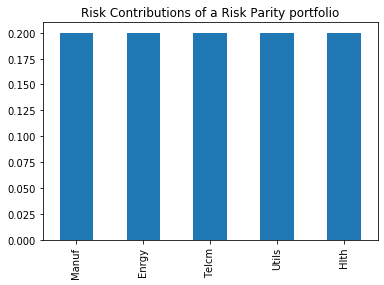

In [30]:
# Risk-parity allocation levels for risk. We see that they are equal i.e 0.2

risk_cont(equal_risk_cont(cov), cov).plot.bar(title="Risk Contributions of a Risk Parity portfolio")

In [50]:
# Find optimal weights to put in each industry based on the above risk-allocation levels above of 0.2

def sample_covariance(rets):
    return rets.cov()

def weight_rp(rets):
    est_cov = sample_covariance(rets)
    return equal_risk_cont(est_cov)

pd.DataFrame(weight_rp(rets) * 100, index = rets.columns, columns = ["Weight"])

,Weight
Manuf,16.508594
Enrgy,9.154375
Telcm,19.352918
Utils,38.005441
Hlth,16.978672


Based on the equally-weighted risk allocations in cell 23, "Util" has the lowest volatility at around 7%. For a risk-parity portfolio, the assets with lower volatility in cell 23 get a larger weight-allocation of 38% as seen with "Util" (cell 50), as in the end all risk-allocations are equal at 0.2. 

As for "Enrgy", we see high volatility of around 37% in cell 23, so it will get a smaller weight-allocation of 9.15% in the risk-parity portfolio (cell 50).